In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_epochs = 100
split = 0.4 # best at 0.7/0.6 . Big difference for 0.3,0.4

# Baseline

In [3]:
df = pd.read_csv('datasets/AAPL.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-02-01,19.462856,19.512857,18.882856,19.107143,12.740701,252686000
1,2008-02-04,19.172857,19.414286,18.774286,18.807142,12.540661,224808500
2,2008-02-05,18.632856,19.142857,18.414286,18.480000,12.322518,285260500
3,2008-02-06,18.690001,18.845715,17.395714,17.428572,11.621424,393318100
4,2008-02-07,17.138571,17.825714,16.752857,17.320000,11.549030,520832900


## We are only going to consider the opening price

In [5]:
df = df.drop(df.columns[2:],axis=1)
df.head()

,Date,Open
0,2008-02-01,19.462856
1,2008-02-04,19.172857
2,2008-02-05,18.632856
3,2008-02-06,18.690001
4,2008-02-07,17.138571


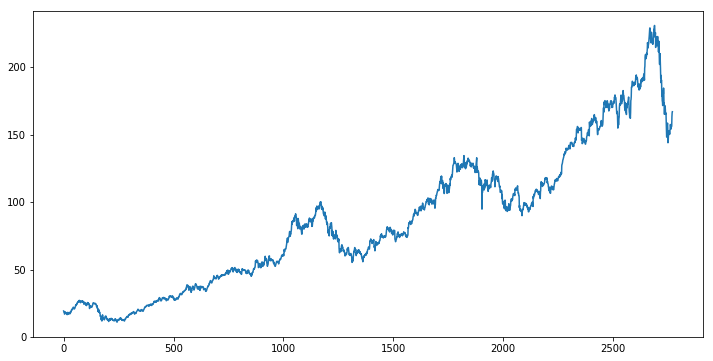

In [6]:
df['Open'].plot(figsize=(12,6))

In [7]:
training = split
total = df.shape[0]
train_index = int(total*training)

training_set = df[:train_index]

## Feature scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(pd.DataFrame(training_set['Open']))

## Take time step to be 60 days

In [9]:
X_train = []
y_train = []
for i in range(60, train_index):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

/home/aveek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.fit(X_train, y_train, epochs = num_epochs, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1048/1048 [==============================] - 7s 6ms/step - loss: 0.0305
Epoch 2/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0031
Epoch 3/100
1048/1048 [==============================] - 3s 3ms/step - loss: 0.0032
Epoch 4/100
1048/1048 [==============================] - 3s 3ms/step - loss: 0.0029
Epoch 5/100
1048/1048 [==============================] - 4s 3ms/step - loss: 0.0030
Epoch 6/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0029
Epoch 7/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0026
Epoch 8/100
1048/1048 [==============================] - 5s 5ms/step - loss: 0.0023
Epoch 9/100
1048/1048 [==============================] - 3s 3ms/step - loss: 0.0028
Epoch 10/100
1048/1048 [==============================] - 3s 3ms/step - loss: 0.0028
Epoch 11/100
1048/1048 [==============================] - 4s 4ms/step - loss: 0.0023
Epoch 12/100
1048/1048 [==

In [13]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Open
1108,2012-06-25,82.471428
1109,2012-06-26,81.618568
1110,2012-06-27,82.142860
1111,2012-06-28,81.667145
1112,2012-06-29,82.571426


In [14]:
real_stock_price = pd.DataFrame(testing_set['Open']).reset_index(drop=True)

In [15]:
test_set=testing_set['Open']
test_set=pd.DataFrame(test_set)

In [16]:
inputs = df['Open'][len(df) - len(testing_set) - 60:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(60, 60+(total-train_index)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [17]:
predicted_stock_price=pd.DataFrame(predicted_stock_price)
predicted_stock_price_old = predicted_stock_price

## Plotting predicted vs actual

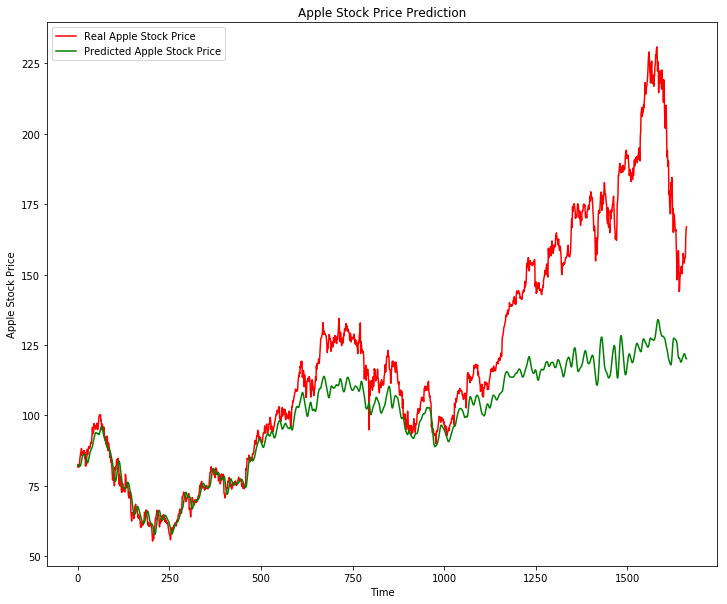

In [18]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_stock_price, color = 'red', label = 'Real Apple Stock Price')
plt.plot(predicted_stock_price_old, color = 'green', label = 'Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

# Using sentiment from news articles and twitter

In [19]:
import pickle
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import mean_squared_error

## Get the cleaned datasets

In [20]:
final_news = pd.read_csv('datasets/news_clean.csv')
final_tweets = pd.read_csv('datasets/tweets_clean.csv')


## Load the saved SVC and vectorizer

In [21]:
l_svc = pickle.load(open('models/linear_regression.sav', 'rb'))
l_svc

/home/aveek/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
from joblib import dump, load

# vectorizer = pickle.load(open('models/tfidf.sav', 'rb'))
vectorizer = load('models/tfidf.xz')

/home/aveek/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/aveek/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

## Predict sentiment

### 1. Predict news articles sentiment

In [41]:
pred = []

for x in final_news['News']:
    sample = x.split("|")

    test_sent = vectorizer.transform(sample)
    prediction = l_svc.predict(test_sent)
    
    su = 0
    for p in prediction:
        su += int(p)

#     pred.append(sum(prediction/len(sample)))
    pred.append(su/len(sample))

In [42]:
df['News'] = pred
df.head()

,Date,Open,News,Tweets,Avg
0,2008-02-01,19.462856,1.00,0.75,0.875
1,2008-02-04,19.172857,0.00,0.80,0.400
2,2008-02-05,18.632856,1.00,0.90,0.950
3,2008-02-06,18.690001,1.00,0.90,0.950
4,2008-02-07,17.138571,0.25,0.80,0.525


### 2. Precict tweets sentiment

In [43]:
pred = []

for x in final_tweets['Tweets']:
    sample = x.split("|")

    test_sent = vectorizer.transform(sample)
    prediction = l_svc.predict(test_sent)

    su = 0
    for p in prediction:
        su += int(p)

#     pred.append(sum(prediction/len(sample)))
    pred.append(su/len(sample))

In [44]:
df['Tweets'] = pred
df.head()

,Date,Open,News,Tweets,Avg
0,2008-02-01,19.462856,1.00,0.75,0.875
1,2008-02-04,19.172857,0.00,0.80,0.400
2,2008-02-05,18.632856,1.00,0.90,0.950
3,2008-02-06,18.690001,1.00,0.90,0.950
4,2008-02-07,17.138571,0.25,0.80,0.525


In [45]:
df['Avg'] = df[['Tweets', 'News']].mean(axis=1)
df.head()

,Date,Open,News,Tweets,Avg
0,2008-02-01,19.462856,1.00,0.75,0.875
1,2008-02-04,19.172857,0.00,0.80,0.400
2,2008-02-05,18.632856,1.00,0.90,0.950
3,2008-02-06,18.690001,1.00,0.90,0.950
4,2008-02-07,17.138571,0.25,0.80,0.525


## Add the sentiment values as new columns

In [46]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

dataset = pd.DataFrame(df['Open'])
# dataset['News'] = df['News']
# dataset['Tweets'] = df['Tweets']
dataset['Avg'] = df['Avg']

dataset_scaled = sc.fit_transform(dataset)

dataset_scaled

array([[0.03701003, 0.82142857],
       [0.03568848, 0.14285714],
       [0.03322765, 0.92857143],
       ...,
       [0.69226012, 0.60714286],
       [0.70529339, 0.89795918],
       [0.70916693, 0.92857143]])

## Split into training and testing

In [47]:
training = split
total = dataset_scaled.shape[0]
train_index = int(total*training)

# training_set_scaled = dataset_scaled[:train_index]

## Taking time window as 60 days

In [48]:
X = []
y = []
for i in range(60, total):
    X.append(dataset_scaled[i-60:i])
    y.append(dataset_scaled[i])
X, y = np.array(X), np.array(y)

# Reshaping
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [49]:
X_train = X[:train_index]
y_train = y[:train_index]
X_test = X[train_index:]
# X_test.shape

## LSTM

In [50]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 2)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 2))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [51]:
model.fit(X_train, y_train, epochs = num_epochs, batch_size = 32)

Epoch 1/100
1108/1108 [==============================] - 7s 6ms/step - loss: 0.0702
Epoch 2/100
1108/1108 [==============================] - 5s 4ms/step - loss: 0.0240
Epoch 3/100
1108/1108 [==============================] - 4s 4ms/step - loss: 0.0183
Epoch 4/100
1108/1108 [==============================] - 3s 3ms/step - loss: 0.0170
Epoch 5/100
1108/1108 [==============================] - 5s 4ms/step - loss: 0.0184
Epoch 6/100
1108/1108 [==============================] - 7s 7ms/step - loss: 0.0171
Epoch 7/100
1108/1108 [==============================] - 6s 5ms/step - loss: 0.0176
Epoch 8/100
1108/1108 [==============================] - 5s 5ms/step - loss: 0.0161
Epoch 9/100
1108/1108 [==============================] - 5s 5ms/step - loss: 0.0168
Epoch 10/100
1108/1108 [==============================] - 4s 4ms/step - loss: 0.0160
Epoch 11/100
1108/1108 [==============================] - 5s 4ms/step - loss: 0.0180
Epoch 12/100
1108/1108 [==============================] - 5s 4ms/step - lo

In [52]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Open,News,Tweets,Avg
1108,2012-06-25,82.471428,0.800000,0.863636,0.831818
1109,2012-06-26,81.618568,0.600000,0.950000,0.775000
1110,2012-06-27,82.142860,0.916667,0.850000,0.883333
1111,2012-06-28,81.667145,0.666667,0.850000,0.758333
1112,2012-06-29,82.571426,0.833333,0.900000,0.866667


In [53]:
real_stock_price = pd.DataFrame(testing_set['Open']).reset_index(drop=True)

In [54]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [55]:
predicted=pd.DataFrame(predicted_stock_price)
real_price = real_stock_price[60:].reset_index(drop=True)
predicted_old = predicted_stock_price_old[60:].reset_index(drop=True)

## Plotting predicted with sentimet vs predicted without sentiment vs actual

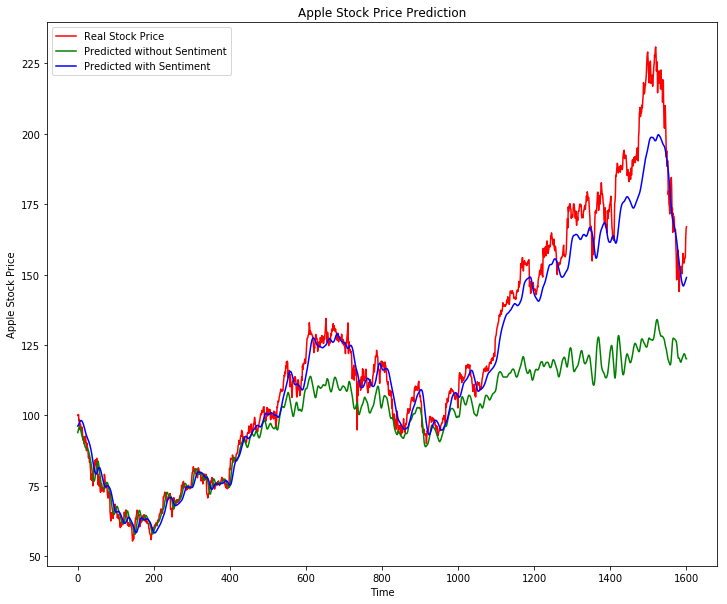

In [56]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_old, color = 'green', label = 'Predicted without Sentiment score')
plt.plot(predicted[0], color = 'blue', label = 'Predicted with Sentiment score')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [57]:
 mean_squared_error(real_price, predicted[0])

65.21445614049522

In [40]:
 mean_squared_error(real_price, predicted_old)

1010.9286819103653